# LeNet网络的实现

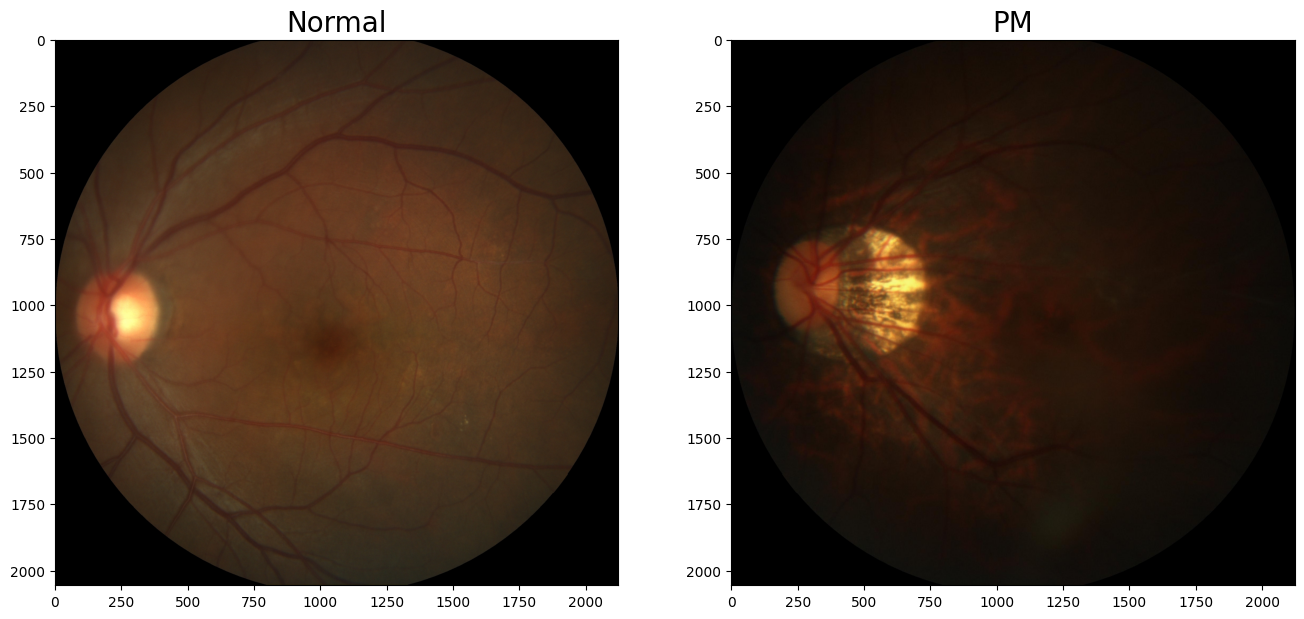

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

DATADIR = 'PALM-Training400'
# 文件名以N开头的是正常眼底图片，以P开头的是病变眼底图片
file1 = 'N0012.jpg'
file2 = 'P0095.jpg'

# 读取图片
img1 = Image.open(os.path.join(DATADIR, file1))
img1 = np.array(img1)
img2 = Image.open(os.path.join(DATADIR, file2))
img2 = np.array(img2)

# 画出读取的图片
plt.figure(figsize=(16, 8))
f = plt.subplot(121)
f.set_title('Normal', fontsize=20)
plt.imshow(img1)
f = plt.subplot(122)
f.set_title('PM', fontsize=20)
plt.imshow(img2)
plt.show()


In [6]:
import cv2
import random
import numpy as np

# 对读入的图像数据进行预处理
def transform_img(img):
    # 将图片尺寸缩放道 224x224
    img = cv2.resize(img, (224, 224))
    # 读入的图像数据格式是[H, W, C]
    # 使用转置操作将其变成[C, H, W]
    img = np.transpose(img, (2,0,1))
    img = img.astype('float32')
    # 将数据范围调整到[-1.0, 1.0]之间
    img = img / 255.
    img = img * 2.0 - 1.0
    return img

# 定义训练集数据读取器
def data_loader(datadir, batch_size=10, mode = 'train'):
    # 将datadir目录下的文件列出来，每条文件都要读入
    filenames = os.listdir(datadir)
    def reader():
        if mode == 'train':
            # 训练时随机打乱数据顺序
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
        for name in filenames:
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            if name[0] == 'H' or name[0] == 'N':
                # H开头的文件名表示高度近似，N开头的文件名表示正常视力
                # 高度近视和正常视力的样本，都不是病理性的，属于负样本，标签为0
                label = 0
            elif name[0] == 'P':
                # P开头的是病理性近视，属于正样本，标签为1
                label = 1
            else:
                raise('Not excepted file name')
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

# 定义验证集数据读取器
def valid_data_loader(datadir, csvfile, batch_size=10, mode='valid'):
    # 打开包含验证集标签的csvfile，并读入其中的内容
    filelists = open(csvfile).readlines()

    def reader():
        batch_imgs = []
        batch_labels = []
        for line in filelists[1:]:
            line = line.strip().split(',')
            # 检查行数据长度是否足够
            if len(line) < 3:
                continue
            name = line[1]
            try:
                label = int(line[2])
            except ValueError:
                # 跳过无法转换为整数的标签
                continue
            # 根据图片文件名加载图片，并对图像数据作预处理
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            if img is None:
                continue  # 如果图片加载失败，跳过该行
            img = transform_img(img)
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

In [3]:
# 查看数据形状
DATADIR = 'PALM-Training400'
train_loader = data_loader(DATADIR, 
                           batch_size=10, mode='train')
data_reader = train_loader()
data = next(data_reader)
data[0].shape, data[1].shape

eval_loader = data_loader(DATADIR, 
                           batch_size=10, mode='eval')
data_reader = eval_loader()
data = next(data_reader)
data[0].shape, data[1].shape


((10, 3, 224, 224), (10, 1))

In [7]:
# -*- coding: utf-8 -*-

# LeNet 识别眼疾图片

import os
import random
import paddle
import paddle.fluid as fluid
import numpy as np

DATADIR = 'PALM-Training400'
DATADIR2 = 'PALM-Validation400'
CSVFILE = 'labels.csv'

# 定义训练过程
def train(model):
    with fluid.dygraph.guard():
        print('start training ... ')
        model.train()
        epoch_num = 5
        # 定义优化器
        opt = fluid.optimizer.Momentum(learning_rate=0.001, momentum=0.9, parameter_list=model.parameters())
        # 定义数据读取器，训练数据读取器和验证数据读取器
        train_loader = data_loader(DATADIR, batch_size=10, mode='train')
        valid_loader = valid_data_loader(DATADIR2, CSVFILE)
        for epoch in range(epoch_num):
            for batch_id, data in enumerate(train_loader()):
                x_data, y_data = data
                img = fluid.dygraph.to_variable(x_data)
                label = fluid.dygraph.to_variable(y_data)
                # 运行模型前向计算，得到预测值
                logits = model(img)
                # 进行loss计算
                loss = fluid.layers.sigmoid_cross_entropy_with_logits(logits, label)
                avg_loss = fluid.layers.mean(loss)

                if batch_id % 10 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
                # 反向传播，更新权重，清除梯度
                avg_loss.backward()
                opt.minimize(avg_loss)
                model.clear_gradients()

            model.eval()
            accuracies = []
            losses = []
            for batch_id, data in enumerate(valid_loader()):
                x_data, y_data = data
                img = fluid.dygraph.to_variable(x_data)
                label = fluid.dygraph.to_variable(y_data)
                # 运行模型前向计算，得到预测值
                logits = model(img)
                # 二分类，sigmoid计算后的结果以0.5为阈值分两个类别
                # 计算sigmoid后的预测概率，进行loss计算
                pred = fluid.layers.sigmoid(logits)
                loss = fluid.layers.sigmoid_cross_entropy_with_logits(logits, label)
                # 计算预测概率小于0.5的类别
                pred2 = pred * (-1.0) + 1.0
                # 得到两个类别的预测概率，并沿第一个维度级联
                pred = fluid.layers.concat([pred2, pred], axis=1)
                acc = fluid.layers.accuracy(pred, fluid.layers.cast(label, dtype='int64'))
                accuracies.append(acc.numpy())
                losses.append(loss.numpy())
            print("[validation] accuracy/loss: {}/{}".format(np.mean(accuracies), np.mean(losses)))
            model.train()

        # save params of model
        fluid.save_dygraph(model.state_dict(), 'palm')
        # save optimizer state
        fluid.save_dygraph(opt.state_dict(), 'palm')


def evaluation(model, params_file_path):
    with fluid.dygraph.guard():
        print('start evaluation .......')
        # 加载模型参数
        model_state_dict, _ = fluid.load_dygraph(params_file_path)
        model.load_dict(model_state_dict)

        model.eval()
        eval_loader = data_loader(DATADIR, 
                           batch_size=10, mode='eval')

        acc_set = []
        avg_loss_set = []
        for batch_id, data in enumerate(eval_loader()):
            x_data, y_data = data
            img = fluid.dygraph.to_variable(x_data)
            label = fluid.dygraph.to_variable(y_data)
            y_data = y_data.astype(np.int64)
            label_64 = fluid.dygraph.to_variable(y_data)

            # 计算预测
            prediction = model(img)

            # 计算精度
            acc = fluid.layers.accuracy(input=prediction, label=label_64)

            # 计算损失函数值
            loss = fluid.layers.sigmoid_cross_entropy_with_logits(prediction, label)
            avg_loss = fluid.layers.mean(loss)

            acc_set.append(float(acc.numpy()))
            avg_loss_set.append(float(avg_loss.numpy()))

        # 求平均精度
        acc_val_mean = np.array(acc_set).mean()
        avg_loss_val_mean = np.array(avg_loss_set).mean()

        print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

In [8]:
# 导入需要的包
import paddle
import paddle.fluid as fluid
import numpy as np
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, Linear

# 定义 LeNet 网络结构
class LeNet(fluid.dygraph.Layer):
    def __init__(self, num_classes=1):
        super(LeNet, self).__init__()

        # 创建卷积和池化层块，每个卷积层使用Sigmoid激活函数，后面跟着一个2x2的池化
        self.conv1 = Conv2D(num_channels=3, num_filters=6, filter_size=5, act='sigmoid')
        self.pool1 = Pool2D(pool_size=2, pool_stride=2, pool_type='max')
        self.conv2 = Conv2D(num_channels=6, num_filters=16, filter_size=5, act='sigmoid')
        self.pool2 = Pool2D(pool_size=2, pool_stride=2, pool_type='max')
        # 创建第3个卷积层
        self.conv3 = Conv2D(num_channels=16, num_filters=120, filter_size=4, act='sigmoid')
        # 创建全连接层，第一个全连接层的输出神经元个数为64， 第二个全连接层输出神经元个数为分类标签的类别数
        self.fc1 = Linear(input_dim=300000, output_dim=64, act='sigmoid')
        self.fc2 = Linear(input_dim=64, output_dim=num_classes)
    # 网络的前向计算过程
    def forward(self, x, label=None):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = fluid.layers.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        x = self.fc2(x)
        if label is not None:
            acc = fluid.layers.accuracy(input=x, label=label)
            return x, acc
        else:
            return x

if __name__ == '__main__':
    # 创建模型
    with fluid.dygraph.guard():
        model = LeNet(num_classes=1)

    train(model)
    evaluation(model, params_file_path="palm")

start training ... 
epoch: 0, batch_id: 0, loss is: [0.7266408]


KeyboardInterrupt: 

# AlexNet在眼疾筛查数据集iChallenge-PM上具体实现

In [14]:
# -*- coding:utf-8 -*-

# 导入需要的包
import paddle
import paddle.fluid as fluid
import numpy as np
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, Linear


# 定义 AlexNet 网络结构
class AlexNet(fluid.dygraph.Layer):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        
        # AlexNet与LeNet一样也会同时使用卷积和池化层提取图像特征
        # 与LeNet不同的是激活函数换成了‘relu’
        self.conv1 = Conv2D(num_channels=3, num_filters=96, filter_size=11, stride=4, padding=5, act='relu')
        self.pool1 = Pool2D(pool_size=2, pool_stride=2, pool_type='max')
        self.conv2 = Conv2D(num_channels=96, num_filters=256, filter_size=5, stride=1, padding=2, act='relu')
        self.pool2 = Pool2D(pool_size=2, pool_stride=2, pool_type='max')
        self.conv3 = Conv2D(num_channels=256, num_filters=384, filter_size=3, stride=1, padding=1, act='relu')
        self.conv4 = Conv2D(num_channels=384, num_filters=384, filter_size=3, stride=1, padding=1, act='relu')
        self.conv5 = Conv2D(num_channels=384, num_filters=256, filter_size=3, stride=1, padding=1, act='relu')
        self.pool5 = Pool2D(pool_size=2, pool_stride=2, pool_type='max')

        self.fc1 = Linear(input_dim=12544, output_dim=4096, act='relu')
        self.drop_ratio1 = 0.5
        self.fc2 = Linear(input_dim=4096, output_dim=4096, act='relu')
        self.drop_ratio2 = 0.5
        self.fc3 = Linear(input_dim=4096, output_dim=num_classes)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool5(x)
        x = fluid.layers.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        # 在全连接之后使用dropout抑制过拟合
        x= fluid.layers.dropout(x, self.drop_ratio1)
        x = self.fc2(x)
        # 在全连接之后使用dropout抑制过拟合
        x = fluid.layers.dropout(x, self.drop_ratio2)
        x = self.fc3(x)
        return x
if __name__ == '__main__':
    # 创建模型
    with fluid.dygraph.guard():
        model = AlexNet(num_classes=1)

    train(model)
    evaluation(model, params_file_path="palm")

start training ... 
epoch: 0, batch_id: 0, loss is: [0.71448666]
epoch: 0, batch_id: 10, loss is: [0.71795654]
epoch: 0, batch_id: 20, loss is: [0.72894657]
epoch: 0, batch_id: 30, loss is: [0.58944607]
[validation] accuracy/loss: nan/nan
epoch: 1, batch_id: 0, loss is: [0.58050764]
epoch: 1, batch_id: 10, loss is: [0.5220056]
epoch: 1, batch_id: 20, loss is: [0.34596378]
epoch: 1, batch_id: 30, loss is: [0.3519147]
[validation] accuracy/loss: nan/nan
epoch: 2, batch_id: 0, loss is: [0.32452244]
epoch: 2, batch_id: 10, loss is: [0.3438201]
epoch: 2, batch_id: 20, loss is: [0.3931408]
epoch: 2, batch_id: 30, loss is: [0.10808699]
[validation] accuracy/loss: nan/nan
epoch: 3, batch_id: 0, loss is: [0.2859559]
epoch: 3, batch_id: 10, loss is: [0.04332783]
epoch: 3, batch_id: 20, loss is: [0.15474966]
epoch: 3, batch_id: 30, loss is: [0.27483684]
[validation] accuracy/loss: nan/nan
epoch: 4, batch_id: 0, loss is: [0.04675302]
epoch: 4, batch_id: 10, loss is: [0.27927062]
epoch: 4, batch_id

# VGG

In [5]:
# -*- coding:utf-8 -*-

# VGG模型代码
import numpy as np
import paddle
import paddle.fluid as fluid
from paddle.fluid.layer_helper import LayerHelper
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, BatchNorm, Linear
from paddle.fluid.dygraph.base import to_variable

# 定义vgg块，包含多层卷积和1层2x2的最大池化层
class vgg_block(fluid.dygraph.Layer):
    def __init__(self, num_convs, in_channels, out_channels):
        """
        num_convs, 卷积层的数目
        num_channels, 卷积层的输出通道数，在同一个Incepition块内，卷积层输出通道数是一样的
        """
        super(vgg_block, self).__init__()
        self.conv_list = []
        for i in range(num_convs):
            conv_layer = self.add_sublayer('conv_' + str(i), Conv2D(num_channels=in_channels, 
                                        num_filters=out_channels, filter_size=3, padding=1, act='relu'))
            self.conv_list.append(conv_layer)
            in_channels = out_channels
        self.pool = Pool2D(pool_stride=2, pool_size = 2, pool_type='max')
    def forward(self, x):
        for item in self.conv_list:
            x = item(x)
        return self.pool(x)

class VGG(fluid.dygraph.Layer):
    def __init__(self, conv_arch=((2, 64), 
                                (2, 128), (3, 256), (3, 512), (3, 512))):
        super(VGG, self).__init__()
        self.vgg_blocks=[]
        iter_id = 0
        # 添加vgg_block
        # 这里一共5个vgg_block，每个block里面的卷积层数目和输出通道数由conv_arch指定
        in_channels = [3, 64, 128, 256, 512, 512]
        for (num_convs, num_channels) in conv_arch:
            block = self.add_sublayer('block_' + str(iter_id), 
                    vgg_block(num_convs, in_channels=in_channels[iter_id], 
                              out_channels=num_channels))
            self.vgg_blocks.append(block)
            iter_id += 1
        self.fc1 = Linear(input_dim=512*7*7, output_dim=4096,
                      act='relu')
        self.drop1_ratio = 0.5
        self.fc2= Linear(input_dim=4096, output_dim=4096,
                      act='relu')
        self.drop2_ratio = 0.5
        self.fc3 = Linear(input_dim=4096, output_dim=1)
        
    def forward(self, x):
        for item in self.vgg_blocks:
            x = item(x)
        x = fluid.layers.reshape(x, [x.shape[0], -1])
        x = fluid.layers.dropout(self.fc1(x), self.drop1_ratio)
        x = fluid.layers.dropout(self.fc2(x), self.drop2_ratio)
        x = self.fc3(x)
        return x
with fluid.dygraph.guard():
    model = VGG()

train(model)



start training ... 
epoch: 0, batch_id: 0, loss is: [0.6945489]
epoch: 0, batch_id: 10, loss is: [0.6627323]
epoch: 0, batch_id: 20, loss is: [0.6450372]
epoch: 0, batch_id: 30, loss is: [0.623831]
[validation] accuracy/loss: nan/nan
epoch: 1, batch_id: 0, loss is: [0.7717603]
epoch: 1, batch_id: 10, loss is: [0.5683689]
epoch: 1, batch_id: 20, loss is: [1.0063658]
epoch: 1, batch_id: 30, loss is: [0.1516126]
[validation] accuracy/loss: nan/nan
epoch: 2, batch_id: 0, loss is: [0.60410535]
epoch: 2, batch_id: 10, loss is: [0.29033852]
epoch: 2, batch_id: 20, loss is: [0.5646546]
epoch: 2, batch_id: 30, loss is: [0.34303007]
[validation] accuracy/loss: nan/nan
epoch: 3, batch_id: 0, loss is: [0.22679476]
epoch: 3, batch_id: 10, loss is: [1.0697645]
epoch: 3, batch_id: 20, loss is: [0.40347227]
epoch: 3, batch_id: 30, loss is: [1.0966748]
[validation] accuracy/loss: nan/nan
epoch: 4, batch_id: 0, loss is: [0.40413418]
epoch: 4, batch_id: 10, loss is: [0.43169394]
epoch: 4, batch_id: 20, l

# GoogLeNet

In [9]:
class Inception(fluid.dygraph.Layer):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        '''
        Inception模块的实现代码，
        
        c1,  图(b)中第一条支路1x1卷积的输出通道数，数据类型是整数
        c2，图(b)中第二条支路卷积的输出通道数，数据类型是tuple或list, 
               其中c2[0]是1x1卷积的输出通道数，c2[1]是3x3
        c3，图(b)中第三条支路卷积的输出通道数，数据类型是tuple或list, 
               其中c3[0]是1x1卷积的输出通道数，c3[1]是3x3
        c4,  图(b)中第一条支路1x1卷积的输出通道数，数据类型是整数
        '''
        super(Inception, self).__init__()
        # 依次创建Inception块每条支路上使用到的操作
        self.p1_1 = Conv2D(num_filters=c1, 
                           filter_size=1, act='relu')
        self.p2_1 = Conv2D(num_filters=c2[0], 
                           filter_size=1, act='relu')
        self.p2_2 = Conv2D(num_filters=c2[1], 
                           filter_size=3, padding=1, act='relu')
        self.p3_1 = Conv2D(num_filters=c3[0], 
                           filter_size=1, act='relu')
        self.p3_2 = Conv2D(num_filters=c3[1], 
                           filter_size=5, padding=2, act='relu')
        self.p4_1 = Pool2D(pool_size=3, 
                           pool_stride=1,  pool_padding=1, 
                           pool_type='max')
        self.p4_2 = Conv2D(num_filters=c4, 
                           filter_size=1, act='relu')

    def forward(self, x):
        # 支路1只包含一个1x1卷积
        p1 = self.p1_1(x)
        # 支路2包含 1x1卷积 + 3x3卷积
        p2 = self.p2_2(self.p2_1(x))
        # 支路3包含 1x1卷积 + 5x5卷积
        p3 = self.p3_2(self.p3_1(x))
        # 支路4包含 最大池化和1x1卷积
        p4 = self.p4_2(self.p4_1(x))
        # 将每个支路的输出特征图拼接在一起作为最终的输出结果
        return fluid.layers.concat([p1, p2, p3, p4], axis=1)  


In [5]:
# -*- coding:utf-8 -*-

# GoogLeNet模型代码
import numpy as np
import paddle
import paddle.fluid as fluid
from paddle.fluid.layer_helper import LayerHelper
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, BatchNorm, Linear
from paddle.fluid.dygraph.base import to_variable

# 定义Inception块
class Inception(fluid.dygraph.Layer):
    def __init__(self, c0,c1, c2, c3, c4, **kwargs):
        '''
        Inception模块的实现代码，
        
        c1,  图(b)中第一条支路1x1卷积的输出通道数，数据类型是整数
        c2，图(b)中第二条支路卷积的输出通道数，数据类型是tuple或list, 
               其中c2[0]是1x1卷积的输出通道数，c2[1]是3x3
        c3，图(b)中第三条支路卷积的输出通道数，数据类型是tuple或list, 
               其中c3[0]是1x1卷积的输出通道数，c3[1]是3x3
        c4,  图(b)中第一条支路1x1卷积的输出通道数，数据类型是整数
        '''
        super(Inception, self).__init__()
        # 依次创建Inception块每条支路上使用到的操作
        self.p1_1 = Conv2D(num_channels=c0, num_filters=c1, 
                           filter_size=1, act='relu')
        self.p2_1 = Conv2D(num_channels=c0, num_filters=c2[0], 
                           filter_size=1, act='relu')
        self.p2_2 = Conv2D(num_channels=c2[0], num_filters=c2[1], 
                           filter_size=3, padding=1, act='relu')
        self.p3_1 = Conv2D(num_channels=c0, num_filters=c3[0], 
                           filter_size=1, act='relu')
        self.p3_2 = Conv2D(num_channels=c3[0], num_filters=c3[1], 
                           filter_size=5, padding=2, act='relu')
        self.p4_1 = Pool2D(pool_size=3, 
                           pool_stride=1,  pool_padding=1, 
                           pool_type='max')
        self.p4_2 = Conv2D(num_channels=c0, num_filters=c4, 
                           filter_size=1, act='relu')

    def forward(self, x):
        # 支路1只包含一个1x1卷积
        p1 = self.p1_1(x)
        # 支路2包含 1x1卷积 + 3x3卷积
        p2 = self.p2_2(self.p2_1(x))
        # 支路3包含 1x1卷积 + 5x5卷积
        p3 = self.p3_2(self.p3_1(x))
        # 支路4包含 最大池化和1x1卷积
        p4 = self.p4_2(self.p4_1(x))
        # 将每个支路的输出特征图拼接在一起作为最终的输出结果
        return fluid.layers.concat([p1, p2, p3, p4], axis=1)  
    
class GoogLeNet(fluid.dygraph.Layer):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        # GoogLeNet包含五个模块，每个模块后面紧跟一个池化层
        # 第一个模块包含1个卷积层
        self.conv1 = Conv2D(num_channels=3, num_filters=64, filter_size=7, 
                            padding=3, act='relu')
        # 3x3最大池化
        self.pool1 = Pool2D(pool_size=3, pool_stride=2,  
                            pool_padding=1, pool_type='max')
        # 第二个模块包含2个卷积层
        self.conv2_1 = Conv2D(num_channels=64, num_filters=64, 
                              filter_size=1, act='relu')
        self.conv2_2 = Conv2D(num_channels=64, num_filters=192, 
                              filter_size=3, padding=1, act='relu')
        # 3x3最大池化
        self.pool2 = Pool2D(pool_size=3, pool_stride=2,  
                            pool_padding=1, pool_type='max')
        # 第三个模块包含2个Inception块
        self.block3_1 = Inception(192, 64, (96, 128), (16, 32), 32)
        self.block3_2 = Inception(256, 128, (128, 192), (32, 96), 64)
        # 3x3最大池化
        self.pool3 = Pool2D(pool_size=3, pool_stride=2,  
                               pool_padding=1, pool_type='max')
        # 第四个模块包含5个Inception块
        self.block4_1 = Inception(480, 192, (96, 208), (16, 48), 64)
        self.block4_2 = Inception(512, 160, (112, 224), (24, 64), 64)
        self.block4_3 = Inception(512, 128, (128, 256), (24, 64), 64)
        self.block4_4 = Inception(512, 112, (144, 288), (32, 64), 64)
        self.block4_5 = Inception(528, 256, (160, 320), (32, 128), 128)
        # 3x3最大池化
        self.pool4 = Pool2D(pool_size=3, pool_stride=2,  
                               pool_padding=1, pool_type='max')
        # 第五个模块包含2个Inception块
        self.block5_1 = Inception(832, 256, (160, 320), (32, 128), 128)
        self.block5_2 = Inception(832, 384, (192, 384), (48, 128), 128)
        # 全局池化，尺寸用的是global_pooling，pool_stride不起作用
        self.pool5 = Pool2D(pool_stride=1, 
                               global_pooling=True, pool_type='avg')
        self.fc = Linear(input_dim=1024, output_dim=1, act=None)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2_2(self.conv2_1(x)))
        x = self.pool3(self.block3_2(self.block3_1(x)))
        x = self.block4_3(self.block4_2(self.block4_1(x)))
        x = self.pool4(self.block4_5(self.block4_4(x)))
        x = self.pool5(self.block5_2(self.block5_1(x)))
        x = fluid.layers.reshape(x, [x.shape[0], -1])
        x = self.fc(x)
        return x

if __name__ == '__main__':
    # 创建模型
    with fluid.dygraph.guard():
        model = GoogLeNet(num_classes=1)

    train(model)
    evaluation(model, params_file_path="palm")

TypeError: __init__() got an unexpected keyword argument 'num_classes'

# ResNet

In [10]:
# -*- coding:utf-8 -*-

# ResNet模型代码
import numpy as np
import paddle
import paddle.fluid as fluid
from paddle.fluid.layer_helper import LayerHelper
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, BatchNorm, Linear
from paddle.fluid.dygraph.base import to_variable

# ResNet中使用了BatchNorm层，在卷积层的后面加上BatchNorm以提升数值稳定性
# 定义卷积批归一化块
class ConvBNLayer(fluid.dygraph.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 filter_size,
                 stride=1,
                 groups=1,
                 act=None):
        """
        
        num_channels, 卷积层的输入通道数
        num_filters, 卷积层的输出通道数
        stride, 卷积层的步幅
        groups, 分组卷积的组数，默认groups=1不使用分组卷积
        act, 激活函数类型，默认act=None不使用激活函数
        """
        super(ConvBNLayer, self).__init__()

        # 创建卷积层
        self._conv = Conv2D(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            act=None,
            bias_attr=False)

        # 创建BatchNorm层
        self._batch_norm = BatchNorm(num_filters, act=act)

    def forward(self, inputs):
        y = self._conv(inputs)
        y = self._batch_norm(y)
        return y

# 定义残差块
# 每个残差块会对输入图片做三次卷积，然后跟输入图片进行短接
# 如果残差块中第三次卷积输出特征图的形状与输入不一致，则对输入图片做1x1卷积，将其输出形状调整成一致
class BottleneckBlock(fluid.dygraph.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 stride,
                 shortcut=True):
        super(BottleneckBlock, self).__init__()
        # 创建第一个卷积层 1x1
        self.conv0 = ConvBNLayer(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=1,
            act='relu')
        # 创建第二个卷积层 3x3
        self.conv1 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act='relu')
        # 创建第三个卷积 1x1，但输出通道数乘以4
        self.conv2 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters * 4,
            filter_size=1,
            act=None)

        # 如果conv2的输出跟此残差块的输入数据形状一致，则shortcut=True
        # 否则shortcut = False，添加1个1x1的卷积作用在输入数据上，使其形状变成跟conv2一致
        if not shortcut:
            self.short = ConvBNLayer(
                num_channels=num_channels,
                num_filters=num_filters * 4,
                filter_size=1,
                stride=stride)

        self.shortcut = shortcut

        self._num_channels_out = num_filters * 4

    def forward(self, inputs):
        y = self.conv0(inputs)
        conv1 = self.conv1(y)
        conv2 = self.conv2(conv1)

        # 如果shortcut=True，直接将inputs跟conv2的输出相加
        # 否则需要对inputs进行一次卷积，将形状调整成跟conv2输出一致
        if self.shortcut:
            short = inputs
        else:
            short = self.short(inputs)

        y = fluid.layers.elementwise_add(x=short, y=conv2)
        layer_helper = LayerHelper(self.full_name(), act='relu')
        return layer_helper.append_activation(y)

# 定义ResNet模型
class ResNet(fluid.dygraph.Layer):
    def __init__(self, layers=50, class_dim=1):
        """
        
        layers, 网络层数，可以是50, 101或者152
        class_dim，分类标签的类别数
        """
        super(ResNet, self).__init__()
        self.layers = layers
        supported_layers = [50, 101, 152]
        assert layers in supported_layers, \
            "supported layers are {} but input layer is {}".format(supported_layers, layers)

        if layers == 50:
            #ResNet50包含多个模块，其中第2到第5个模块分别包含3、4、6、3个残差块
            depth = [3, 4, 6, 3]
        elif layers == 101:
            #ResNet101包含多个模块，其中第2到第5个模块分别包含3、4、23、3个残差块
            depth = [3, 4, 23, 3]
        elif layers == 152:
            #ResNet50包含多个模块，其中第2到第5个模块分别包含3、8、36、3个残差块
            depth = [3, 8, 36, 3]
        
        # 残差块中使用到的卷积的输出通道数
        num_filters = [64, 128, 256, 512]

        # ResNet的第一个模块，包含1个7x7卷积，后面跟着1个最大池化层
        self.conv = ConvBNLayer(
            num_channels=3,
            num_filters=64,
            filter_size=7,
            stride=2,
            act='relu')
        self.pool2d_max = Pool2D(
            pool_size=3,
            pool_stride=2,
            pool_padding=1,
            pool_type='max')

        # ResNet的第二到第五个模块c2、c3、c4、c5
        self.bottleneck_block_list = []
        num_channels = 64
        for block in range(len(depth)):
            shortcut = False
            for i in range(depth[block]):
                bottleneck_block = self.add_sublayer(
                    'bb_%d_%d' % (block, i),
                    BottleneckBlock(
                        num_channels=num_channels,
                        num_filters=num_filters[block],
                        stride=2 if i == 0 and block != 0 else 1, # c3、c4、c5将会在第一个残差块使用stride=2；其余所有残差块stride=1
                        shortcut=shortcut))
                num_channels = bottleneck_block._num_channels_out
                self.bottleneck_block_list.append(bottleneck_block)
                shortcut = True

        # 在c5的输出特征图上使用全局池化
        self.pool2d_avg = Pool2D(pool_size=7, pool_type='avg', global_pooling=True)

        # stdv用来作为全连接层随机初始化参数的方差
        import math
        stdv = 1.0 / math.sqrt(2048 * 1.0)
        
        # 创建全连接层，输出大小为类别数目
        self.out = Linear(input_dim=2048, output_dim=class_dim,
                      param_attr=fluid.param_attr.ParamAttr(
                          initializer=fluid.initializer.Uniform(-stdv, stdv)))

        
    def forward(self, inputs):
        y = self.conv(inputs)
        y = self.pool2d_max(y)
        for bottleneck_block in self.bottleneck_block_list:
            y = bottleneck_block(y)
        y = self.pool2d_avg(y)
        y = fluid.layers.reshape(y, [y.shape[0], -1])
        y = self.out(y)
        return y

if __name__ == '__main__':
    # 创建模型
    with fluid.dygraph.guard():
        model = ResNet(num_classes=1)

    train(model)
    evaluation(model, params_file_path="palm")

TypeError: __init__() got an unexpected keyword argument 'num_classes'